In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets
import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filenames = ['experiments/seirhd.yaml', 'experiments/undetected.yaml']
model_params = {
        'SEIRHD': [ 'lockdown_R0', 'T_inc', 'T_inf', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio'],
        'SEIR_undetected': [ 'T_inc', 'T_inf_D', 'T_inf_U', 'T_recov', 'T_recov_fatal', 'beta', 'd', 'P_fatal', 'I_D_hosp_ratio', 'I_U_hosp_ratio', 'E_hosp_ratio'],
    }
model_names = list(model_params.keys())
configs = [read_config(config_filename) for config_filename in config_filenames]

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

In [6]:
predictions_dict.keys()

dict_keys([])

In [7]:
# tuple format (state, district, starting_date, ending_date)
# TODO: take config blocks instead of state or district
location_tuples = [
    ('Maharashtra', 'Mumbai'),
    ('Maharashtra', 'Pune'),
]

------------+---------------------|
| Unnamed: 0  | 45.0                | 46.0                | 47.0                | 48.0                | 49.0                |
| date        | 2020-09-21 00:00:00 | 2020-09-22 00:00:00 | 2020-09-23 00:00:00 | 2020-09-24 00:00:00 | 2020-09-25 00:00:00 |
| S           | 8548364.0           | 8484933.0           | 8419317.0           | 8351504.0           | 8281484.0           |
| E           | 261898.0            | 271944.0            | 282152.0            | 292503.0            | 302978.0            |
| I_D         | 54133.0             | 56340.0             | 58596.0             | 60899.0             | 63245.0             |
| I_U         | 291464.0            | 304024.0            | 316938.0            | 330200.0            | 343800.0            |
| P_U         | 452000.0            | 476811.0            | 502682.0            | 529643.0            | 557724.0            |
| R_severe    | 66120.0             | 69030.0             | 72034.0             | 

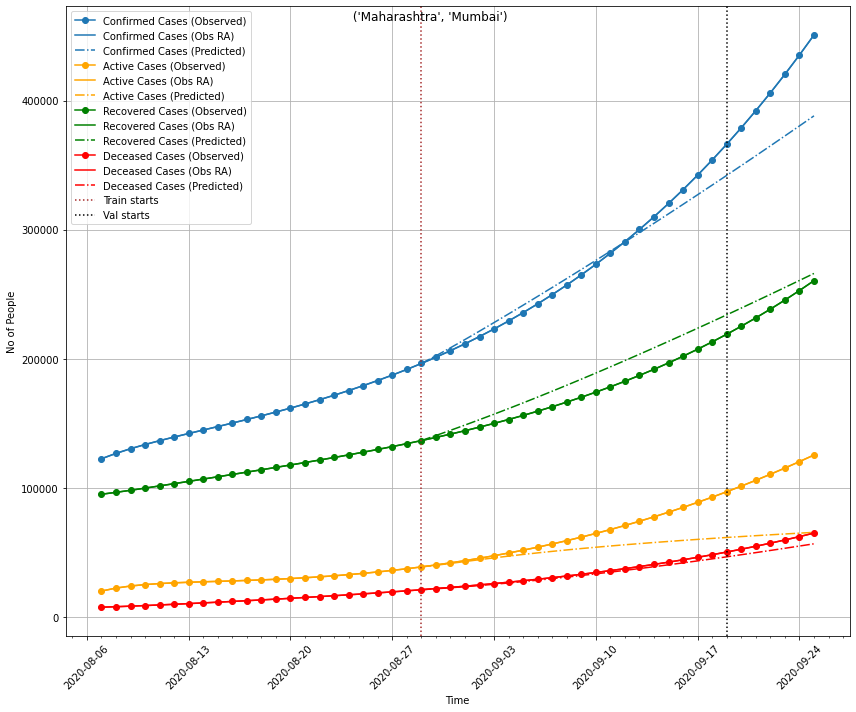

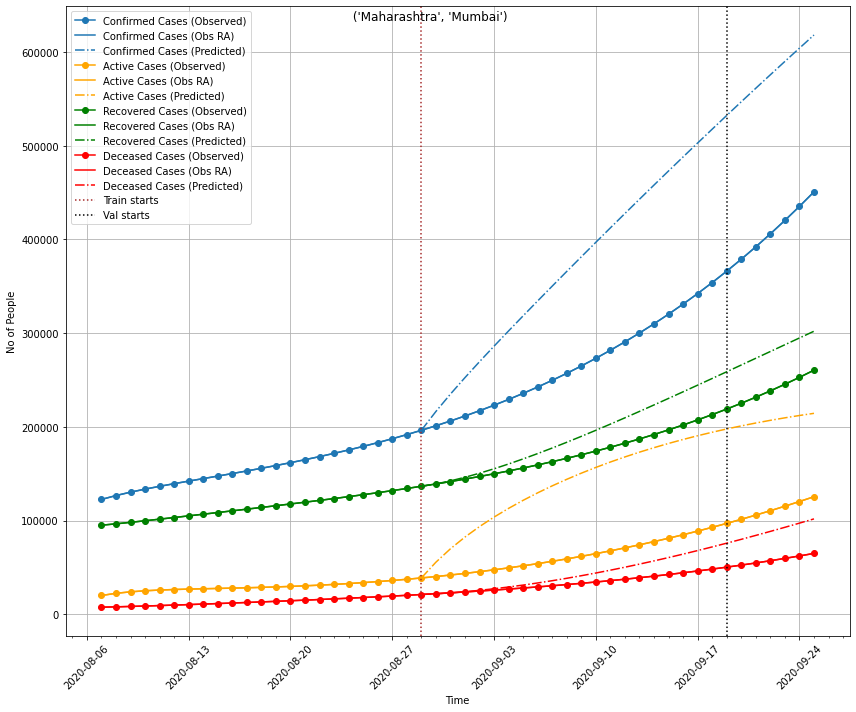

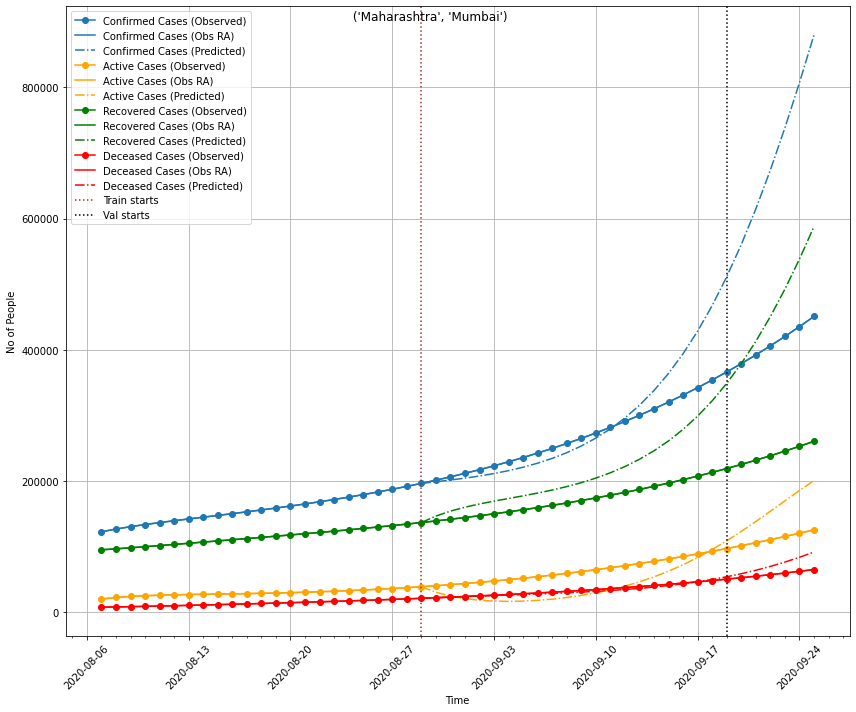

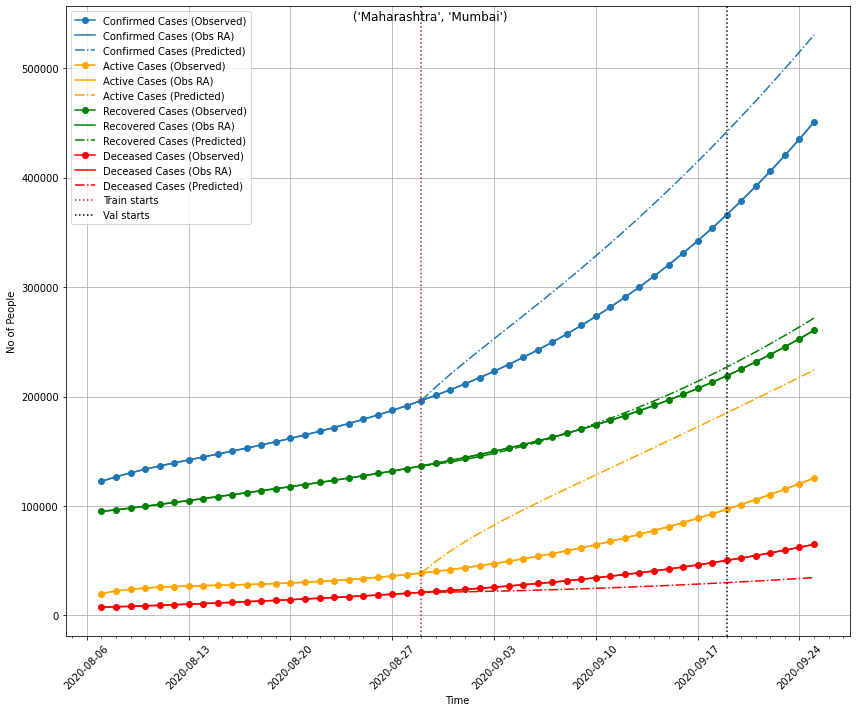

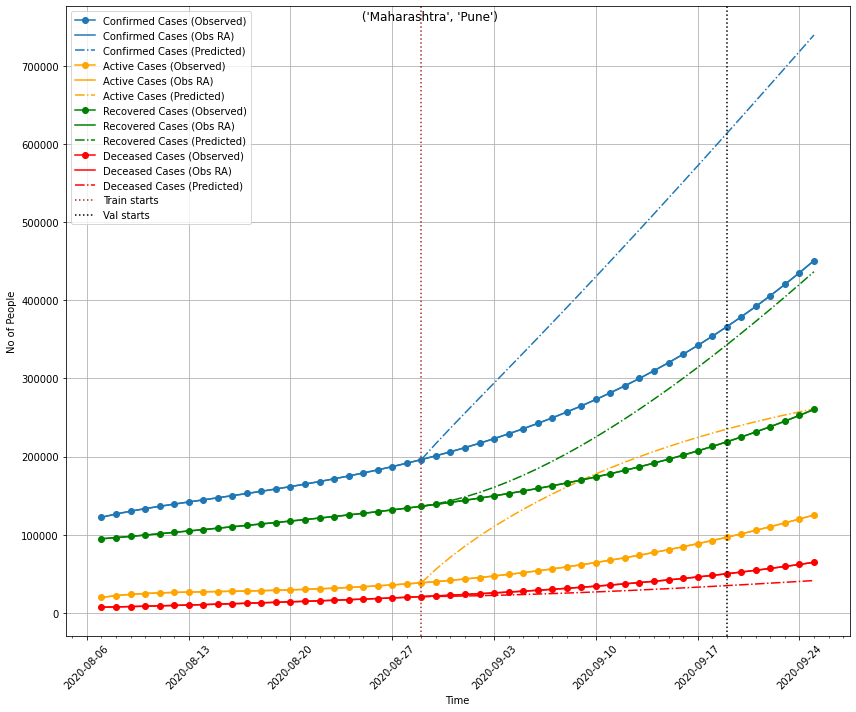

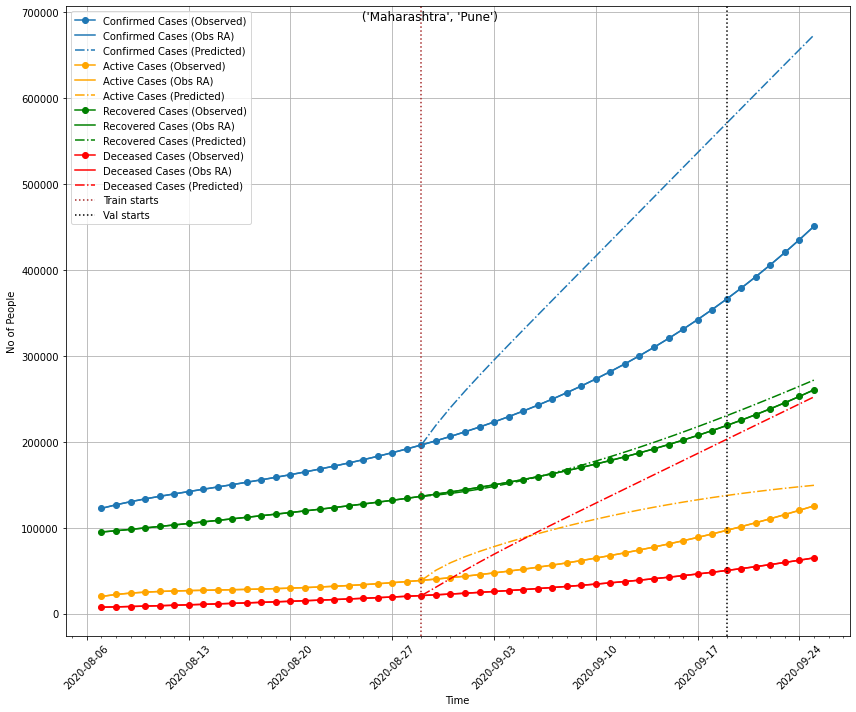

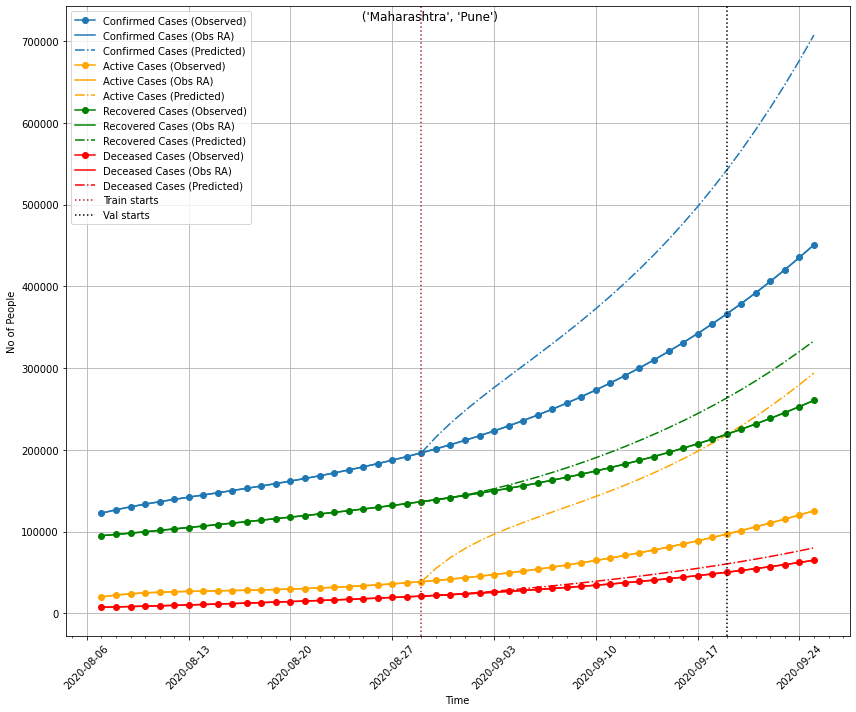

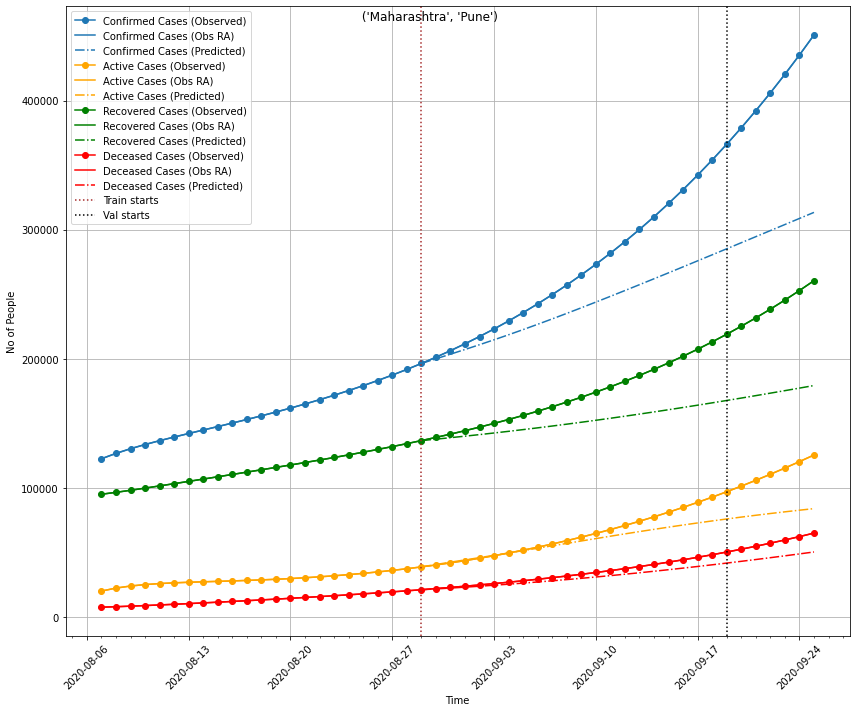

In [8]:
num_rep_trials = 2
for i, loc in enumerate(location_tuples):
    predictions_dict[loc] = {}
    for j, config in enumerate(configs):
        predictions_dict[loc][model_names[j]] = {}
        config_params = copy.deepcopy(config['fitting'])
        config_params['data']['dataloading_params']['state'] = loc[0]
        config_params['data']['dataloading_params']['district'] = loc[1]
        if loc[1] != 'Mumbai':
            config_params['data']['smooth_jump'] = False
        for k in range(num_rep_trials):
            predictions_dict[loc][model_names[j]][f'm{k}'] = single_fitting_cycle(**config_params) 

In [19]:
wandb.init(project="covid-modelling")
wandb.run.name = "degeneracy-exps-location"+wandb.run.name

Traceback (most recent call last):
  File "/Users/siddhantshingi/anaconda3/envs/covid_modelling/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 469, in init
    wi.setup(kwargs)
  File "/Users/siddhantshingi/anaconda3/envs/covid_modelling/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 67, in setup
    self._wl = wandb_setup._setup()
  File "/Users/siddhantshingi/anaconda3/envs/covid_modelling/lib/python3.8/site-packages/wandb/sdk/wandb_setup.py", line 244, in _setup
    wl = _WandbSetup(settings=settings)
  File "/Users/siddhantshingi/anaconda3/envs/covid_modelling/lib/python3.8/site-packages/wandb/sdk/wandb_setup.py", line 233, in __init__
    _WandbSetup._instance = _WandbSetup__WandbSetup(settings=settings)
  File "/Users/siddhantshingi/anaconda3/envs/covid_modelling/lib/python3.8/site-packages/wandb/sdk/wandb_setup.py", line 92, in __init__
    self._settings_setup(settings, self._early_logger)
  File "/Users/siddhantshingi/anaconda3/envs/covid_modelling/lib/

Exception: problem

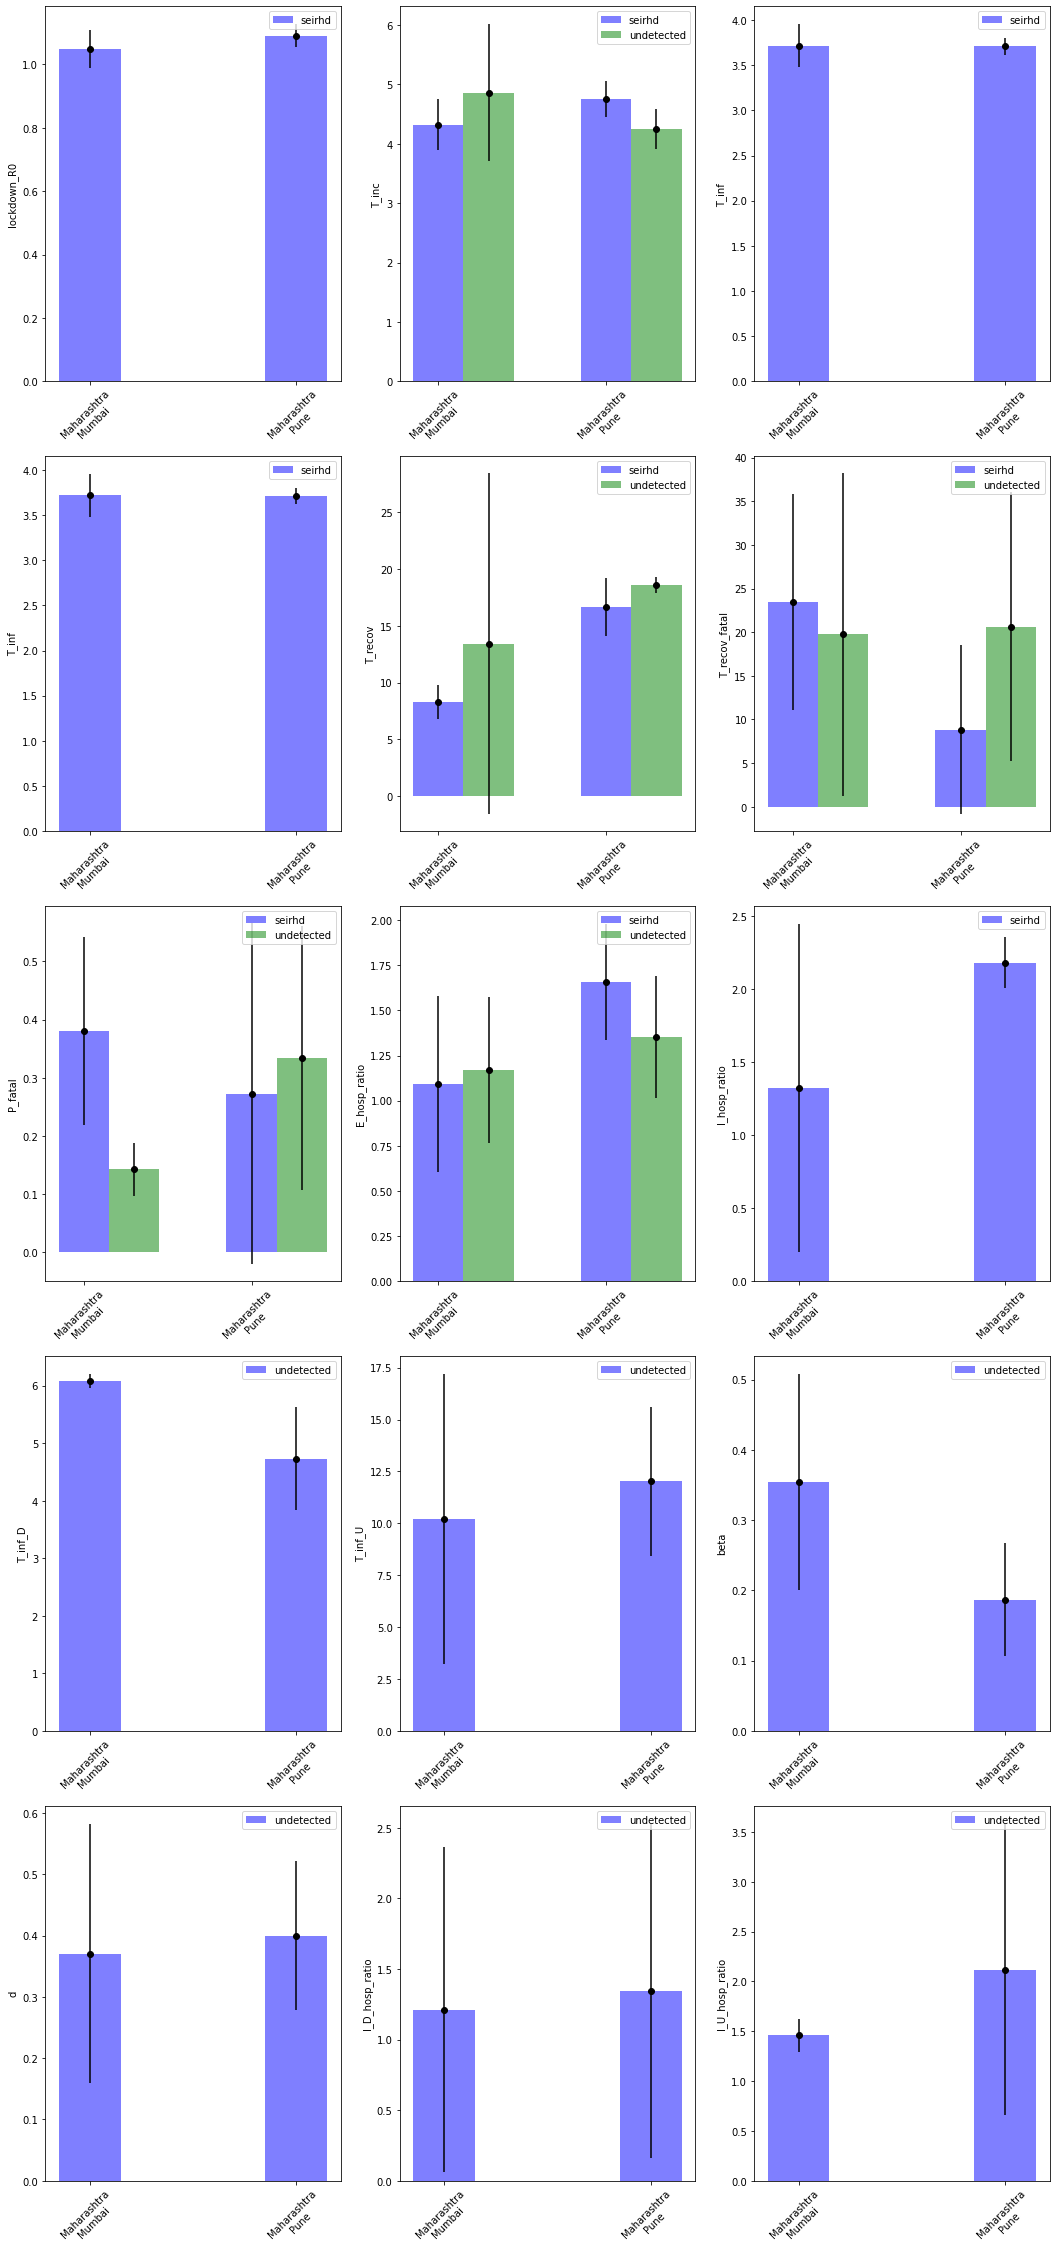

In [9]:
plot_all_params(predictions_dict, model_params)

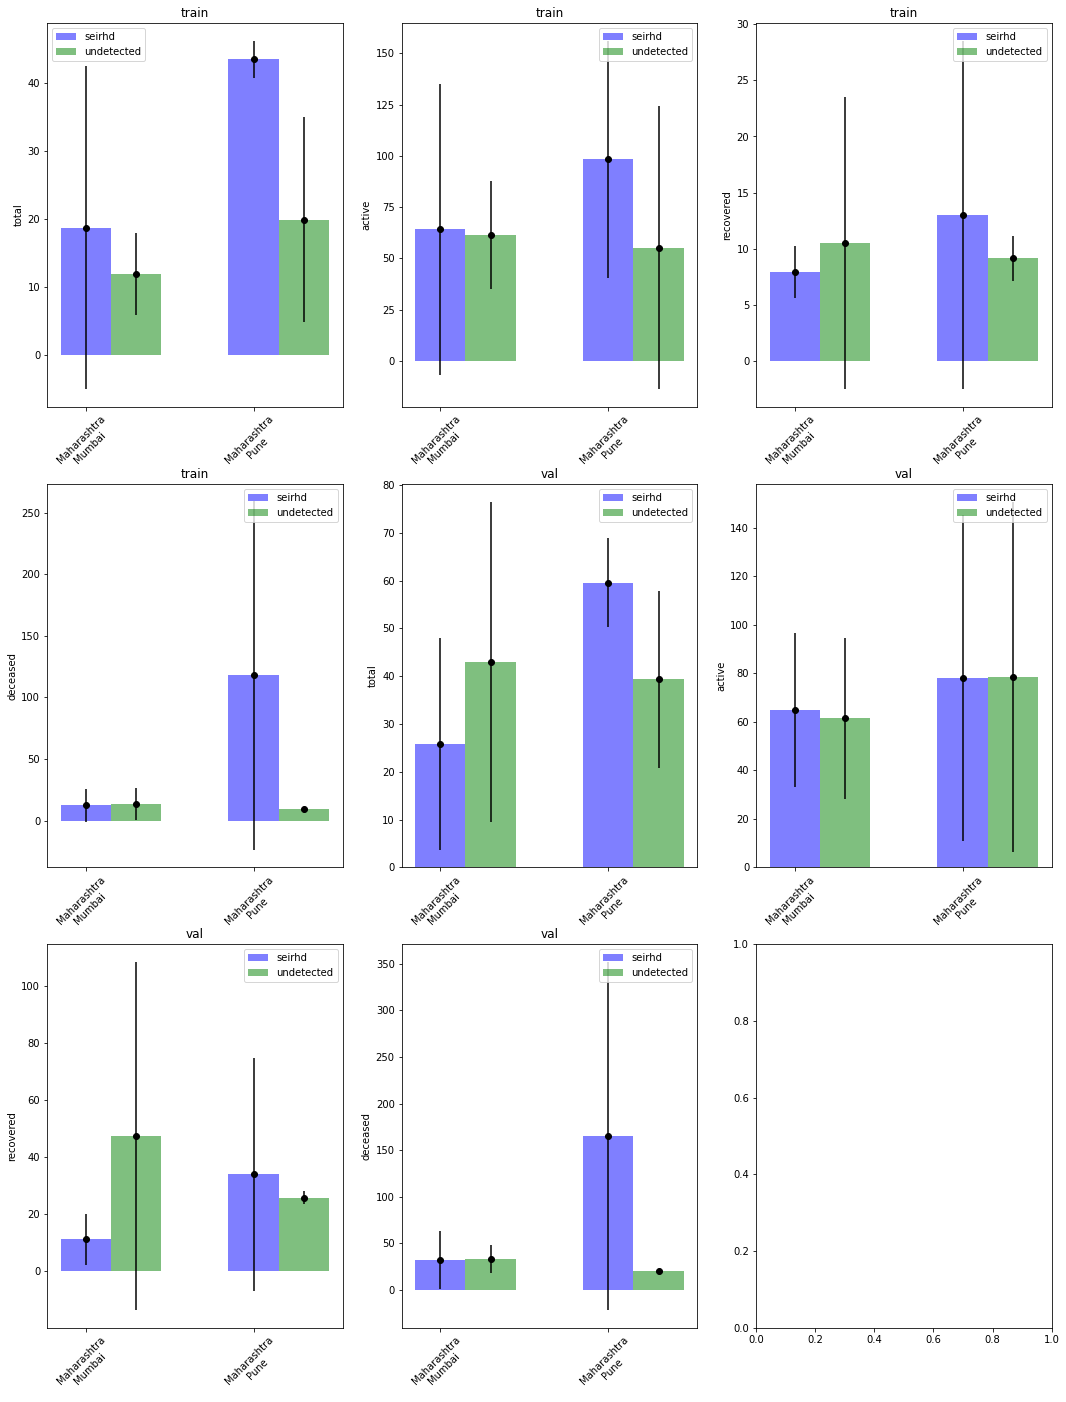

In [11]:
which_compartments = {model_names[i]: config['fitting']['loss']['loss_compartments'] for i, config in enumerate(configs)}
plot_all_losses(predictions_dict, which_losses=['train', 'val'], which_compartments=which_compartments)

In [35]:
plot_all_buckets(predictions_dict, which_buckets=['S'], compare='model')

TypeError: 'module' object is not callable

In [13]:
predictions_dict[('Maharashtra','Pune')]['seirhd']['m0'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'smoothing_description', 'df_district_unsmoothed', 'run_params'])

In [15]:
predictions_dict[('Maharashtra','Pune')]['undetected']['m0']['df_prediction']

,date,S,E,I_D,I_U,P_U,R_severe,R_fatal,C,D,active,recovered,deceased,total
0,2020-08-29,9615647,61608,84432,42011,0,31967,6737,136565,21029,38704,136565,21029,196298
1,2020-08-30,9586777,73556,73457,47649,3069,45766,9249,138616,21856,55015,138616,21856,215487
2,2020-08-31,9558691,82201,65931,54161,6560,57072,11149,141321,22909,68221,141321,22909,232451
3,2020-09-01,9530566,88979,60859,61189,10515,66572,12612,144571,24133,79184,144571,24133,247888
4,2020-09-02,9501814,94829,57552,68523,14965,74775,13765,148282,25491,88540,148282,25491,262313
5,2020-09-03,9472031,100313,55559,76065,19926,82049,14701,152397,26956,96750,152397,26956,276103
6,2020-09-04,9440930,105750,54594,83785,25410,88656,15484,156877,28509,104140,156877,28509,289526
7,2020-09-05,9408260,111387,54421,91674,31430,94826,16171,161690,30136,110997,161690,30136,302823
8,2020-09-06,9373840,117337,54903,99756,37997,100717,16799,166817,31830,117516,166817,31830,316163
9,2020-09-07,9337509,123664,55948,108064,45127,106450,17395,172250,33588,123845,172250,33588,329683


In [31]:
predictions_dict[('Maharashtra','Pune')]['undetected']['m0'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'smoothing_description', 'df_district_unsmoothed', 'run_params'])